In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

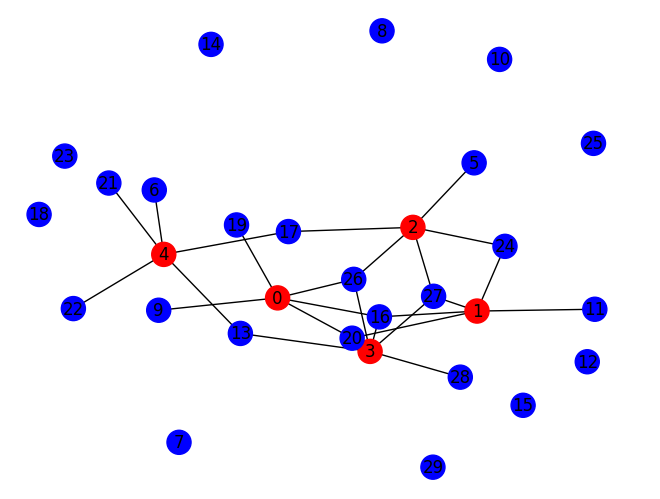

In [ ]:
def create_graph(num_human_nodes, num_mosquito_nodes, mosquito_to_human_ratio):
    G = nx.Graph()

    # Crear nodos de humanos
    human_nodes = list(range(num_human_nodes))
    G.add_nodes_from(human_nodes, node_type='Human')

    # Crear nodos de mosquitos
    mosquito_nodes = list(range(num_human_nodes, num_human_nodes+num_mosquito_nodes))
    G.add_nodes_from(mosquito_nodes, node_type='Mosquito')

    # Conectar nodos humanos con nodos de mosquitos
    for human_node in human_nodes:
        num_mosquito_links = round(mosquito_to_human_ratio)
        mosquito_links = random.sample(mosquito_nodes, num_mosquito_links)
        G.add_edges_from([(human_node, mosquito_node) for mosquito_node in mosquito_links])

    return G

# Parámetros
num_human_nodes = 5  # Número de nodos humanos
mosquito_to_human_ratio = 5  # Relación mosquito a humano
num_mosquito_nodes = num_human_nodes * mosquito_to_human_ratio  # Cantidad de nodos de mosquitos

# Crear el grafo con el mosquito to human ratio actual
VB_graph = create_graph(num_human_nodes, num_mosquito_nodes, mosquito_to_human_ratio)

# Visualizar el grafo
node_colors = ['red' if VB_graph.nodes[node]['node_type'] == 'Human' else 'blue' for node in VB_graph.nodes()]
pos = nx.spring_layout(VB_graph, k=0.5)
nx.draw(VB_graph, with_labels=True, node_color=node_colors, pos = pos)
plt.show()



In [ ]:
def create_graph(num_human_nodes, num_mosquito_nodes, mosquito_to_human_ratio):
    G = nx.Graph()

    # Crear nodos de humanos
    human_nodes = ['H' + str(i) for i in range(num_human_nodes)]
    G.add_nodes_from(human_nodes, node_type='Human')

    # Crear nodos de mosquitos
    mosquito_nodes = ['M' + str(i) for i in range(num_mosquito_nodes)]
    G.add_nodes_from(mosquito_nodes, node_type='Mosquito')

    # Conectar nodos humanos con nodos de mosquitos
    for human_node in human_nodes:
        num_mosquito_links = round(mosquito_to_human_ratio)
        mosquito_links = random.sample(mosquito_nodes, num_mosquito_links)
        G.add_edges_from([(human_node, mosquito_node) for mosquito_node in mosquito_links])

    return G

In [ ]:
# Parámetros del modelo
num_nodes = 100  # Número total de nodos en la red
infection_prob_human = 0.5  # Probabilidad de infección humana por picadura
infection_prob_mosquito = 0.5  # Probabilidad de infección de mosquito a humano
mortality_rate_mosquito = 0.05  # Tasa de mortalidad de los mosquitos por unidad de tiempo
biting_rate = 0.5  # Tasa de contacto entre mosquitos y humanos
num_iterations = 100  # Número de iteraciones de la simulación
recovery_rate_human = 0.05
num_human_nodes = 100  # Número de nodos humanos
mosquito_to_human_ratio = 5  # Relación mosquito a humano
num_mosquito_nodes = num_human_nodes * mosquito_to_human_ratio  # Cantidad de nodos de mosquitos


# Crear el grafo con el mosquito to human ratio actual
VB_graph = create_graph(num_human_nodes, num_mosquito_nodes, mosquito_to_human_ratio)


# Función para simular el modelo Ross-Macdonald
def simulate_ross_model(graph, infection_prob_human, infection_prob_mosquito,
                                  mortality_rate_mosquito, biting_rate, mosquito_to_human_ratio,
                                  num_iterations):

    node_types = nx.get_node_attributes(graph, 'node_type')
    total_mosquitoes = set(node for node, node_type in node_types.items() if node_type == 'Mosquito')
    total_humans = set(node for node, node_type in node_types.items() if node_type == 'Human')
    infected_humans = set()
    infected_mosquitoes = set()

    quantity_timestamp = None
    quantity_infected_humans = []
    quantity_susceptible_humans = []
    quantity_infected_mosquitoes = []
    quantity_susceptible_mosquitoes= []

    # Seleccionar un nodo al azar de los nodos de tipo "mosquito"
    random_mosquito_node = random.choice(list(total_mosquitoes))
    random_human_node = random.choice(list(total_humans))

    infection_data = {'timestamp': [], 'num_infected_human': [], 'num_susceptible_human': [],
                      'num_infected_mosquito': [], 'num_susceptible_mosquito': []}
    infected_mosquitoes.add(random_mosquito_node)
    infected_humans.add(random_human_node)

    for i in range(num_iterations):
        # Crear una copia del conjunto de nodos infectados para evitar iterar sobre un conjunto cambiante
        current_infected_mosquitoes = list(infected_mosquitoes)
        current_infected_humans = list(infected_humans)
        quantity_infected_mosquitoes.append(len(current_infected_mosquitoes))
        quantity_susceptible_mosquitoes.append(len(total_mosquitoes) - len(current_infected_mosquitoes))
        quantity_infected_humans.append(len(current_infected_humans))
        quantity_susceptible_humans.append(len(total_humans) - len(current_infected_humans))

        # Simulación para mosquitos
        for mosquito in current_infected_mosquitoes:
          human_neighbors = list(graph.neighbors(mosquito))

          # Propagar la infección a los humanos
          for h_neighbor in human_neighbors:
            if h_neighbor not in current_infected_humans and np.random.random() < (biting_rate * infection_prob_human):
                infected_humans.add(h_neighbor)
        for human in current_infected_humans:
          mosquitoes_neighbors = list(graph.neighbors(human))
          # Propagar la infección a los mosquitos
          for m_neighbor in mosquitoes_neighbors:
            if m_neighbor not in current_infected_mosquitoes and np.random.random() < infection_prob_mosquito:
              infected_mosquitoes.add(m_neighbor)

          # Recuperar los nodos infectados con cierta probabilidad
          if np.random.random() < recovery_rate_human:
            infected_humans.remove(human)
    quantity_timestamp = pd.DataFrame({'timestamp':np.arange(0,num_iterations), 'humans_infected':np.array(quantity_infected_humans),
                                       'num_susceptible_humans':np.array(quantity_susceptible_humans), 'mosquitoes_infected':np.array(quantity_infected_mosquitoes),
                                       'mosquitoes_susceptible':np.array(quantity_susceptible_mosquitoes)})
    return infected_mosquitoes, infected_humans, quantity_timestamp

# Simular el modelo Ross-Macdonald
infected_mosquitoes, infected_humans, infection_data = simulate_ross_model(VB_graph, infection_prob_human,
                                                                                     infection_prob_mosquito,
                                                                                     mortality_rate_mosquito,
                                                                                     biting_rate,
                                                                                     mosquito_to_human_ratio,
                                                                                     num_iterations)


In [ ]:
infection_data['humans_infected'] = infection_data['humans_infected'] / num_human_nodes
infection_data['mosquitoes_infected'] = infection_data['mosquitoes_infected'] / num_mosquito_nodes
infection_data['num_susceptible_humans'] = infection_data['num_susceptible_humans'] / num_human_nodes
infection_data['mosquitoes_susceptible'] = infection_data['mosquitoes_susceptible'] / num_mosquito_nodes

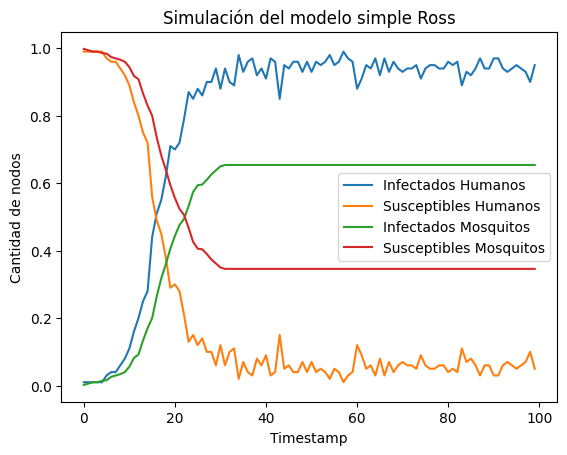

In [ ]:
plt.plot(infection_data['timestamp'], infection_data['humans_infected'], label='Infectados Humanos')
plt.plot(infection_data['timestamp'], infection_data['num_susceptible_humans'], label='Susceptibles Humanos')
plt.plot(infection_data['timestamp'], infection_data['mosquitoes_infected'], label='Infectados Mosquitos')
plt.plot(infection_data['timestamp'], infection_data['mosquitoes_susceptible'], label='Susceptibles Mosquitos')
plt.xlabel('Timestamp')
plt.ylabel('Proporción de nodos')
plt.title('Simulación del modelo simple Ross')
plt.legend()
plt.show()